### 实验2 用卷积神经网络的姓氏分类

*WA2114001王晗宇*

该实验同时发布于（不急，还没发布）

**目录**

**一、实验要点**

**二、实验原理（卷积神经网络）**

    2.1 二维卷积原理
    
      2.1.1 二维卷积原理

      2.1.2 卷积神经网络里面的卷积原理
      
      2.1.3 卷积神经网络里面的卷积编码（PyTorch）
    
    2.2 卷积神经网络（Convolutional Neural Networks）基本结构

**三、实验步骤**

    3.1 数据集处理（三大类Vocabulary、SurnameVectorizer和SurnameDataset）

    3.2 姓氏分类器模型

    3.3 训练和验证（三个准备函数、两个辅助函数（和一堆检查）：）

    3.4 测试（测试集测试、手动测试）


### 一、实验要点


* 通过“示例:使用卷积神经网络姓氏分类”，掌握卷积神经网络在多层分类中的应用

* 掌握每种类型的神经网络层对它所计算的数据张量的大小和形状的影响

### 二、实验原理（卷积神经网络）


**2.1 卷积**

卷积神经网络（Convolutional Neural Networks,CNN），名称源于经典的数学运算卷积。

**2.1.1 二维卷积原理**

二维卷积运算是一种用于图像处理和计算机视觉的操作，涉及将一个核（也称为滤波器或卷积核）与输入图像进行逐点卷积。

1. 输入图像：假设输入图像为一个大小为 M X N 的矩阵I。

2. 卷积核：假设卷积核为一个大小为 k X k 的矩阵K,(通常是1x1,3x3 或 5x5)。

3. 输出图像：根据 $O(i,j)=\sum_{m=0}^{k-1}{\sum_{n=0}^{k-1}{K(m,n)\cdot I(i+m,j+n)}}$ 输出图像，same卷积大小为 (M - k + 1) X (N - k + 1)。

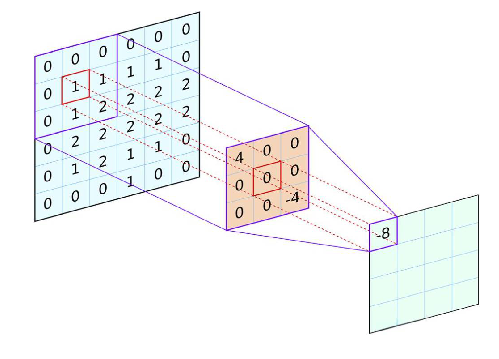

In [39]:
# 防止导出文件发布github/CSDN导致图片丢失，我就用代码读取并显示了
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_path = "why_CNN_imgs/2.1.jpg"
image = Image.open(image_path)
image_array = np.array(image)
plt.figure(figsize=(8, 6))
plt.imshow(image_array)
plt.axis('off')
plt.show()

图2.1 二维卷积原理(图来源于百度，比我自己画的好看)



**2.1.2 卷积神经网络里面的卷积原理**

机器学习中的卷积输入是一个矩阵，输入矩阵与单个产生输出矩阵的卷积核在输入矩阵的每个位置应用内核。内核乘以输入矩阵的值及其自身的值，然后将这些乘法相加。

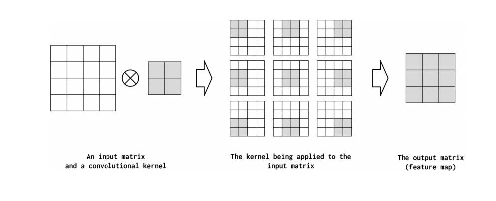

In [42]:
image = np.array(Image.open("why_CNN_imgs/2.2.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.2 卷积原理

它具有以下几个超参数：

（1）输入通道数：

通常卷积输入是三维的，处理图片（矩阵）的W（宽）、H（高），还有一个通道数，例如彩色图像通道数为3（RGB）。卷积核的通道数和输入通道数一样，结果在每个通道对应位置也相加。

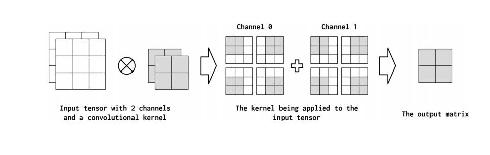

In [43]:
image = np.array(Image.open("why_CNN_imgs/2.3.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.3 输入通道

 （2）输出通道数：

卷积个数才是卷积结果的通道数

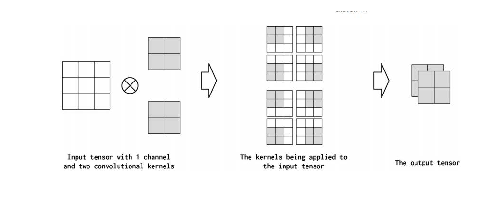

In [44]:
image = np.array(Image.open("why_CNN_imgs/2.4.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.4 输出通道

  （3）核大小：

卷积核的大小呗，上面几个例子是2\*2，下面画个3\*3的

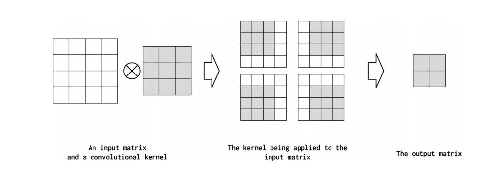

In [47]:
image = np.array(Image.open("why_CNN_imgs/2.5.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.5 卷积核大小3*3

  

（4）步长：

卷积核每次移动距离

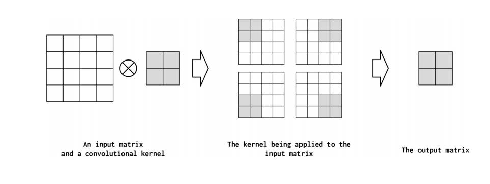

In [48]:
image = np.array(Image.open("why_CNN_imgs/2.6.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.6 步长为2




 （5）填充：

原图像周围填充圈数，分为三种（Full卷积、Same卷积、Valid卷积）

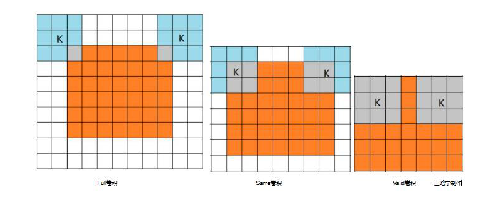

In [50]:
image = np.array(Image.open("why_CNN_imgs/2.7.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.7 填充（原图来自https://blog.csdn.net/leviopku/article/details/80327478，王晗宇改动）




 （6）膨胀(DILATION，核元素之间的间距)：

默认是1，膨胀为2意味着核的元素彼此之间有一个空格

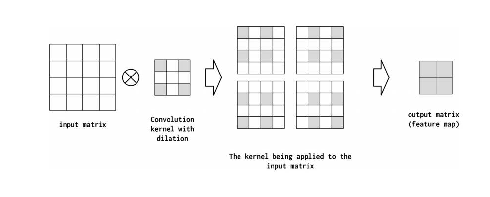

In [51]:
image = np.array(Image.open("why_CNN_imgs/2.8.jpg"))
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

图2.8 膨胀（空洞卷积）







当然我的建议是不清楚卷积的可以看这个大佬写的：

https://baijiahao.baidu.com/s?id=1665589065842103551&wfr=spider&for=pc

**2.1.3 卷积神经网络里面的卷积编码（PyTorch）**

torch.nn里面有Conv1d（一维卷积）和Conv2d（二维卷积）

先试试一维卷积

In [58]:
import torch
import torch.nn as nn

# 批量大小
batch_size = 2

# 向量大小
one_hot_size = 10

# 序列宽度
sequence_width = 7

# 创建一个随机张量，尺寸为 (叭拉叭拉)
data = torch.randn(batch_size, one_hot_size, sequence_width)

# 一维卷积
conv1 = nn.Conv1d(in_channels=one_hot_size, out_channels=16, kernel_size=3)

# 将数据传入卷积层
intermediate1 = conv1(data)

print(f"输入大小{data.size()}")
print(f"输出大小{intermediate1.size()}")


输入大小torch.Size([2, 10, 7])
输出大小torch.Size([2, 16, 5])


二维卷积输入一堆变量（2.1.2节介绍的超参数）：

in_channels（int）；输入通道数

out_channels（int）：输出通道数

kernel_size（int或元组）；核大小

stride（int或tuple）；步长。默认1

padding（int或tuple）：零填充，默认0

dilation（int或tuple）：膨胀（核元素之间的间距），默认1

bias（布尔）—如果为True，则将可学习的偏差添加到输出中，默认True

In [59]:
conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)

intermediate2 = conv2(intermediate1)
intermediate3 = conv3(intermediate2)

print(f"二维卷积输出大小{intermediate2.size()}")
print(f"三维卷积输出大小{intermediate3.size()}")

二维卷积输出大小torch.Size([2, 32, 3])
三维卷积输出大小torch.Size([2, 64, 1])


**2.2 卷积神经网络（Convolutional Neural Networks）基本结构**

卷积神经网络（Convolutional Neural Networks, CNNs）是一类深度学习模型，广泛应用于计算机视觉领域，如图像分类、目标检测、图像分割等。CNNs 通过卷积操作提取输入数据中的局部特征，同时通过池化操作降低数据的维度，从而高效地学习和处理高维度的数据。下面是卷积神经网络的基本结构：

1. 卷积层（Convolutional Layer）

卷积层是卷积神经网络的核心组件，通过卷积核（滤波器）对输入数据进行卷积操作，提取局部特征。每个卷积核通过在输入数据上滑动，计算局部区域的加权和来生成特征图。

公式：$\text{Feature Map}_{i,j} = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (\text{Input}_{i+m,j+n} \cdot \text{Kernel}_{m,n}) + \text{Bias}$

2. 激活函数（Activation Function）

卷积层通常会跟一个非线性激活函数，用于引入非线性，使模型能够学习更复杂的特征，我（王晗宇）用到的常见有以下几种。

ReLU: $\text{ReLU}(x) = \max(0, x)$

Sigmoid: $\sigma(x) = \frac{1}{1 + e^{-x}}$

Tanh: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$


3. 池化层（Pooling Layer）

池化层通过下采样操作减少特征图的尺寸，从而降低计算复杂度和内存使用，同时保持重要的特征信息。常用的池化操作有最大池化（Max Pooling）和平均池化（Average Pooling）。

最大池化（Max Pooling）：$ \text{Max Pooling}(x) = \max(x)$

最大池化（Max Pooling）：$ \text{Average Pooling}(x) = \frac{\sum_{i=1}^{王晗宇}{x_i}}{王晗宇}$

4. 全连接层（Fully Connected Layer）

全连接层将卷积层和池化层提取的特征展开成一维向量，并通过一个或多个全连接层进行分类或回归任务。全连接层与传统的神经网络类似，所有输入节点与输出节点全连接。

5. Softmax 层（Softmax Layer）

Softmax 层通常用于分类任务的最后一层，将输出转换为概率分布，用于多类别分类。

公式：$ \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{N} e^{z_j}}$


In [60]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)  # 假设输入图像大小为32x32

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)  # 展平特征图
        x = self.fc1(x)
        return x


input_tensor = torch.randn(1, 3, 32, 32)  # 输入
model = SimpleCNN()
output = model(input_tensor)
print(output.size())  # 输出的大小

torch.Size([1, 10])


### 三、实验步骤

先Import一堆包包

In [1]:
from argparse import Namespace  # 处理命令行参数的
from collections import Counter  # 计数的
import json  # 处理JSON数据的
import os  # 处理操作系统的
import string

import numpy as np  # 计算器
import pandas as pd
import torch
import torch.nn as nn  # 王晗宇曰：好东西
import torch.nn.functional as F  # 神经网络功能模块
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook  # 画进度条的

### 3.1 数据集处理（三大类Vocabulary、SurnameVectorizer和SurnameDataset）

In [6]:
class Vocabulary(object):
    """处理文本并提取词汇以进行映射的类"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        输入：token_to_idx（dict）——预先存在的token到索引的映射字典
              add_unk（bool）——是否添加UNK（未知）token的标志
              unk_token（str）——要添加到词汇表中的UNK token
        输出：无
        功能：创建token到索引的映射，处理UNK token
        by 王晗宇
        """
        if token_to_idx is None:
            token_to_idx = {}  # 如果没有提供token到索引的映射字典，则初始化为空字典
        self._token_to_idx = token_to_idx  # 保存token到索引的映射字典

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}  # 创建索引到token的反向映射字典
        
        self._add_unk = add_unk  # 保存是否添加UNK token的标志
        self._unk_token = unk_token  # 保存UNK token的值
        
        self.unk_index = -1  # 初始化UNK token的索引为-1
        if add_unk:
            self.unk_index = self.add_token(unk_token)  # 添加UNK token并获取其索引
        
    def to_serializable(self):
        """
        输入：无
        输出：包含词汇表信息的可序列化字典
        功能：返回一个可以序列化的词汇表字典
        by 王晗宇
        """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}  # 返回词汇表的序列化字典

    @classmethod
    def from_serializable(cls, contents):
        """
        输入：contents（dict）——包含词汇表信息的序列化字典
        输出：Vocabulary类实例
        功能：从序列化字典实例化词汇表
        by 王晗宇
        """
        return cls(**contents)  # 使用序列化字典创建Vocabulary实例

    def add_token(self, token):
        """
        输入：token（str）——要添加到词汇表中的token
        输出：index（int）——对应于该token的整数索引
        功能：根据token更新映射字典
        by 王晗宇
        """
        try:
            index = self._token_to_idx[token]  # 尝试获取token的索引
        except KeyError:
            index = len(self._token_to_idx)  # 如果token不在映射字典中，则使用新的索引
            self._token_to_idx[token] = index  # 更新token到索引的映射
            self._idx_to_token[index] = token  # 更新索引到token的反向映射
        return index  # 返回token的索引
    
    def add_many(self, tokens):
        """
        输入：tokens（list）——字符串token列表
        输出：indices（list）——对应于这些token的索引列表
        功能：将一个token列表添加到词汇表中
        by 王晗宇
        """
        return [self.add_token(token) for token in tokens]  # 添加多个token，并返回其索引列表

    def lookup_token(self, token):
        """
        输入：token（str）——要查找的token
        输出：index（int）——对应于该token的索引
        功能：检索与token关联的索引，如果token不存在则返回UNK索引
        注意：`unk_index`需要>=0（已添加到词汇表中）以启用UNK功能 
        by 王晗宇
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)  # 如果有UNK token，返回其索引
        else:
            return self._token_to_idx[token]  # 否则返回token的索引

    def lookup_index(self, index):
        """
        输入：index（int）——要查找的索引
        输出：token（str）——对应于该索引的token
        功能：返回与索引关联的token
        异常：KeyError——如果索引不在词汇表中
        by 王晗宇
        """
        if index not in self._idx_to_token:
            raise KeyError("索引 (%d) 不在词汇表中" % index)  # 如果索引不在反向映射字典中，则抛出异常
        return self._idx_to_token[index]  # 返回索引对应的token

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)  # 返回词汇表的字符串表示，包含其大小

    def __len__(self):
        return len(self._token_to_idx)  # 返回词汇表的大小


In [7]:
class SurnameVectorizer(object):
    """ 协调词汇表并使用它们的向量化器 """
    
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        输入：surname_vocab（Vocabulary）——将字符映射到整数的词汇表
              nationality_vocab（Vocabulary）——将国籍映射到整数的词汇表
              max_surname_length（int）——最长姓氏的长度
        输出：无
        功能：创建姓氏和国籍的词汇表，并记录最长姓氏的长度
        by 王晗宇
        """
        self.surname_vocab = surname_vocab  # 保存姓氏词汇表
        self.nationality_vocab = nationality_vocab  # 保存国籍词汇表
        self._max_surname_length = max_surname_length  # 保存最长姓氏的长度

    def vectorize(self, surname):
        """
        输入：surname（str）——姓氏
        输出：one_hot_matrix（np.ndarray）——一个one-hot向量矩阵
        功能：将姓氏向量化为one-hot矩阵
        by 王晗宇
        """
        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)  # 确定one-hot矩阵的大小
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)  # 初始化one-hot矩阵
                               
        for position_index, character in enumerate(surname):  # 遍历姓氏中的字符
            character_index = self.surname_vocab.lookup_token(character)  # 查找字符的索引
            one_hot_matrix[character_index][position_index] = 1  # 将对应位置置为1
        
        return one_hot_matrix  # 返回one-hot矩阵

    @classmethod
    def from_dataframe(cls, surname_df):
        """
        输入：surname_df（pandas.DataFrame）——姓氏数据集
        输出：SurnameVectorizer的实例
        功能：从数据集的DataFrame实例化向量化器
        by 王晗宇
        """
        surname_vocab = Vocabulary(unk_token="@")  # 初始化姓氏词汇表
        nationality_vocab = Vocabulary(add_unk=False)  # 初始化国籍词汇表
        max_surname_length = 0  # 初始化最长姓氏的长度

        for index, row in surname_df.iterrows():  # 遍历数据集的每一行
            max_surname_length = max(max_surname_length, len(row.surname))  # 更新最长姓氏的长度
            for letter in row.surname:  # 遍历姓氏中的每个字符
                surname_vocab.add_token(letter)  # 将字符添加到姓氏词汇表中
            nationality_vocab.add_token(row.nationality)  # 将国籍添加到国籍词汇表中

        return cls(surname_vocab, nationality_vocab, max_surname_length)  # 返回向量化器的实例

    @classmethod
    def from_serializable(cls, contents):
        """
        输入：contents（dict）——包含词汇表信息的序列化字典
        输出：SurnameVectorizer的实例
        功能：从序列化字典实例化向量化器
        by 王晗宇
        """
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])  # 从序列化字典中获取姓氏词汇表
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])  # 从序列化字典中获取国籍词汇表
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])  # 返回向量化器的实例

    def to_serializable(self):
        """
        输入：无
        输出：包含词汇表信息的可序列化字典
        功能：返回一个可以序列化的词汇表字典
        by 王晗宇
        """
        return {'surname_vocab': self.surname_vocab.to_serializable(),  # 序列化姓氏词汇表
                'nationality_vocab': self.nationality_vocab.to_serializable(),  # 序列化国籍词汇表
                'max_surname_length': self._max_surname_length}  # 序列化最长姓氏长度


In [8]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        输入：surname_df（pandas.DataFrame）——数据集
              vectorizer（SurnameVectorizer）——从数据集中实例化的向量化器
        输出：无
        功能：创建数据集并设置划分
        by 王晗宇
        """
        self.surname_df = surname_df  # 保存数据集
        self._vectorizer = vectorizer  # 保存向量化器
        self.train_df = self.surname_df[self.surname_df.split=='train']  # 提取训练集
        self.train_size = len(self.train_df)  # 计算训练集大小

        self.val_df = self.surname_df[self.surname_df.split=='val']  # 提取验证集
        self.validation_size = len(self.val_df)  # 计算验证集大小

        self.test_df = self.surname_df[self.surname_df.split=='test']  # 提取测试集
        self.test_size = len(self.test_df)  # 计算测试集大小

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}  # 创建划分字典

        self.set_split('train')  # 设置默认划分为训练集
        
        # 计算类别权重
        class_counts = surname_df.nationality.value_counts().to_dict()  # 统计每个国籍的数量
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])  # 按国籍词汇表中的索引排序
        sorted_counts = sorted(class_counts.items(), key=sort_key)  # 排序国籍统计结果
        frequencies = [count for _, count in sorted_counts]  # 获取频率列表
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)  # 计算类别权重

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """
        输入：surname_csv（str）——数据集的位置
        输出：SurnameDataset的实例
        功能：加载数据集并从头开始创建一个新的向量化器
        by 王晗宇
        """
        surname_df = pd.read_csv(surname_csv)  # 读取CSV文件
        train_surname_df = surname_df[surname_df.split=='train']  # 提取训练集
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))  # 创建并返回SurnameDataset实例

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """
        输入：surname_csv（str）——数据集的位置
              vectorizer_filepath（str）——保存的向量化器的位置
        输出：SurnameDataset的实例
        功能：加载数据集和相应的向量化器，适用于向量化器已缓存以供重用的情况
        by 王晗宇
        """
        surname_df = pd.read_csv(surname_csv)  # 读取CSV文件
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)  # 加载向量化器
        return cls(surname_df, vectorizer)  # 创建并返回SurnameDataset实例

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """
        输入：vectorizer_filepath（str）——序列化向量化器的位置
        输出：SurnameVectorizer的实例
        功能：从文件加载向量化器的静态方法
        by 王晗宇
        """
        with open(vectorizer_filepath) as fp:  # 打开文件
            return SurnameVectorizer.from_serializable(json.load(fp))  # 读取并返回序列化向量化器

    def save_vectorizer(self, vectorizer_filepath):
        """
        输入：vectorizer_filepath（str）——保存向量化器的位置
        输出：无
        功能：使用json将向量化器保存到磁盘
        by 王晗宇
        """
        with open(vectorizer_filepath, "w") as fp:  # 打开文件以写入
            json.dump(self._vectorizer.to_serializable(), fp)  # 序列化并保存向量化器

    def get_vectorizer(self):
        """
        输入：无
        输出：向量化器
        功能：返回向量化器
        by 王晗宇
        """
        return self._vectorizer  # 返回向量化器

    def set_split(self, split="train"):
        """
        输入：split（str）——数据集的划分
        输出：无
        功能：使用数据框中的列选择数据集的划分
        by 王晗宇
        """
        self._target_split = split  # 设置当前划分
        self._target_df, self._target_size = self._lookup_dict[split]  # 更新目标数据集和大小

    def __len__(self):
        """
        输入：无
        输出：目标数据集的大小
        功能：返回目标数据集的大小
        by 王晗宇
        """
        return self._target_size  # 返回目标数据集的大小

    def __getitem__(self, index):
        """
        输入：index（int）——数据点的索引
        输出：包含数据点特征（x_data）和标签（y_target）的字典
        功能：PyTorch数据集的主要入口方法
        by 王晗宇
        """
        row = self._target_df.iloc[index]  # 获取索引对应的数据行

        surname_matrix = self._vectorizer.vectorize(row.surname)  # 向量化姓氏

        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)  # 查找国籍索引

        return {'x_surname': surname_matrix,  # 返回包含特征和标签的字典
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """
        输入：batch_size（int）——批量大小
        输出：数据集中的批次数量
        功能：给定批量大小，返回数据集中的批次数量
        by 王晗宇
        """
        return len(self) // batch_size  # 返回批次数量

def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    """
    输入：dataset（Dataset）——数据集
          batch_size（int）——批量大小
          shuffle（bool）——是否打乱数据
          drop_last（bool）——是否丢弃最后一个不完整的批次
          device（str）——设备（"cpu"或"cuda"）
    输出：批次数据生成器
    功能：包装PyTorch的DataLoader的生成器函数，确保每个张量在正确的设备位置上
    by 王晗宇
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)  # 创建DataLoader

    for data_dict in dataloader:  # 遍历DataLoader中的数据字典
        out_data_dict = {}  # 初始化输出数据字典
        for name, tensor in data_dict.items():  # 遍历数据字典中的每个条目
            out_data_dict[name] = data_dict[name].to(device)  # 将张量移动到指定设备
        yield out_data_dict  # 生成输出数据字典


###  3.2 姓氏分类器模型

我们定义一个标准卷积神经网络：

输入 --> [CONV1D] --> [ELU] --> [CONV1D] --> [ELU] --> [CONV1D] --> [ELU] --> [CONV1D] --> [ELU] --> [FC] --> 输出（分类）

具体来说，这网络要能适用于任意形状，那么输入和输出必须是传进来的参数：

输入 -->

[CONV1D (输入: initial_num_channels, 输出: num_channels, kernel_size=3)] --> [ELU] --> 

[CONV1D (输入: num_channels, 输出: num_channels, kernel_size=3, stride=2)] --> [ELU] -->

[CONV1D (输入: num_channels, 输出: num_channels, kernel_size=3, stride=2)] --> [ELU] --> 

[CONV1D (输入: num_channels, 输出: num_channels, kernel_size=3)] --> [ELU] --> 

[FC (输入: num_channels, 输出: num_classes)] -->

输出


In [10]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        输入：initial_num_channels（int）——输入特征向量的大小
              num_classes（int）——输出预测向量的大小
              num_channels（int）——整个网络中使用的恒定通道大小
        输出：无
        功能：构建卷积神经网络结构
        by 王晗宇
        """
        super(SurnameClassifier, self).__init__()  # 调用父类的构造函数
        
        self.convnet = nn.Sequential(  # 定义卷积神经网络
            nn.Conv1d(in_channels=initial_num_channels, 
                      out_channels=num_channels, kernel_size=3),  # 第一个卷积层
            nn.ELU(),  # ELU激活函数
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),  # 第二个卷积层
            nn.ELU(),  # ELU激活函数
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),  # 第三个卷积层
            nn.ELU(),  # ELU激活函数
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3),  # 第四个卷积层
            nn.ELU()  # ELU激活函数
        )
        self.fc = nn.Linear(num_channels, num_classes)  # 全连接层

    def forward(self, x_surname, apply_softmax=False):
        """
        输入：x_surname（torch.Tensor）——输入数据张量，形状应为（batch, initial_num_channels, max_surname_length）
              apply_softmax（bool）——是否应用softmax激活函数，使用交叉熵损失时应为False
        输出：预测向量，形状应为（batch, num_classes）
        功能：执行分类器的前向传递
        by 王晗宇
        """
        features = self.convnet(x_surname).squeeze(dim=2)  # 通过卷积神经网络提取特征，并在第三维度上压缩

        prediction_vector = self.fc(features)  # 通过全连接层生成预测向量

        if apply_softmax:  # 如果需要应用softmax
            prediction_vector = F.softmax(prediction_vector, dim=1)  # 应用softmax激活函数

        return prediction_vector  # 返回预测向量


### 3.3 训练和验证

三个准备函数：

In [12]:
def make_train_state(args):
    """
    输入：args (argparse.Namespace) - 包含训练参数的命名空间
    输出：train_state (dict) - 训练状态的字典
    功能：创建训练状态字典（说白了就是训练的主要参数）
    by 王晗宇
    """
    return {'stop_early': False,  # 控制是否提前停止训练
            'early_stopping_step': 0,  # 提前停止训练的步数
            'early_stopping_best_val': 1e8,  # 最佳验证集损失值（用于提前停止训练）
            'learning_rate': args.learning_rate,  # 学习率
            'epoch_index': 0,  # 当前训练轮次
            'train_loss': [],  # 训练集损失值列表
            'train_acc': [],  # 训练集准确率列表
            'val_loss': [],  # 验证集损失值列表
            'val_acc': [],  # 验证集准确率列表
            'test_loss': -1,  # 测试集损失值
            'test_acc': -1,  # 测试集准确率
            'model_filename': args.model_state_file}  # 模型文件名（用于保存训练状态）


In [13]:
def update_train_state(args, model, train_state):
    """
    输入：args (argparse.Namespace) - 主要参数（训练状态字典）
          model (torch.nn.Module) - 要训练的模型
          train_state (dict) - 表示训练状态值的字典
    输出：更新后的train_state (dict) - 表示训练状态值的字典
    功能：处理训练状态的更新，包括早期停止和模型检查点
    by 王晗宇
    """

    # 至少保存一个模型
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False  # 重置提前停止标志

    # 如果经过至少一轮训练
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]  # 获取前两次验证集损失值

        # 如果损失值变大
        if loss_t >= train_state['early_stopping_best_val']:
            # 更新步数
            train_state['early_stopping_step'] += 1
        # 如果损失值减小
        else:
            # 保存最佳模型
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 重置早期停止步数
            train_state['early_stopping_step'] = 0

        # 是否提前停止训练？
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


In [14]:
def compute_accuracy(y_pred, y_target):
    """
    输入：y_pred (torch.Tensor) - 预测向量
          y_target (torch.Tensor) - 真实标签
    输出：accuracy (float)
    功能：计算模型的accuracy呗（准确率）
    by 王晗宇
    """
    y_pred_indices = y_pred.max(dim=1)[1]  # 获取预测向量中的最大值索引（即预测标签）
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # 计算预测正确的数量
    return n_correct / len(y_pred_indices) * 100  # 计算accuracy并转换为百分比


两个辅助函数（和一堆检查）：

In [20]:
args = Namespace(
    # 数据和路径信息
    surname_csv="surnames_with_splits.csv",  # 姓氏数据集的CSV文件路径
    vectorizer_file="vectorizer.json",  # 向量化器文件路径
    model_state_file="model.pth",  # 模型状态文件路径
    save_dir="model_storage/ch4/cnn",  # 保存模型和向量化器的文件夹路径
    # 模型超参数
    hidden_dim=100,  # 隐藏层维度
    num_channels=256,  # 卷积层通道数
    # 训练超参数
    seed=1337,  # 随机种子
    learning_rate=0.001,  # 学习率
    batch_size=128,  # 批处理大小
    num_epochs=15,  # 训练轮数（我电脑就不100次了）
    early_stopping_criteria=5,  # 提前停止训练的条件
    dropout_p=0.1,  # dropout概率
    # 运行时选项
    cuda=False,  # 是否使用CUDA加速
    reload_from_files=False,  # 是否重新加载已保存的模型和向量化器
    expand_filepaths_to_save_dir=True,  # 是否将文件路径扩展到保存文件夹中
    catch_keyboard_interrupt=True  # 是否捕获键盘中断异常
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)  # 扩展向量化器文件路径
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)  # 扩展模型状态文件路径
    print("扩展的文件路径: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# 检查CUDA是否可用
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")  # 设置设备（CPU或CUDA）
print("使用CUDA吗？: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    """
    输入：seed (int) - 随机种子
          cuda (bool) - 是否使用CUDA
    输出：无
    功能：设置全局随机种子以确保结果的可重复性
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    """
    输入：dirpath (str) - 文件夹路径
    输出：无
    功能：检查文件夹是否存在，如果不存在则创建一个
    """
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# 设置随机种子以确保结果的可重复性
set_seed_everywhere(args.seed, args.cuda)

# 处理文件夹
handle_dirs(args.save_dir)  # 检查保存文件夹是否存在，如果不存在则创建


扩展的文件路径: 
	model_storage/ch4/cnn/vectorizer.json
	model_storage/ch4/cnn/model.pth
使用CUDA吗？: False


In [21]:
if args.reload_from_files:
    # 如果设置为从文件重新加载，则加载数据集和向量化器
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # 否则创建新的数据集和向量化器，并保存向量化器到文件中
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

# 初始化分类器
classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab), 
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

# 将分类器移到指定设备上
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

# 交叉熵损失函数
loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)

# 优化器为我（WA2114001王晗宇）最喜欢的Adam优化器
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

# 定义学习率调度器为ReduceLROnPlateau，用于动态调整学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

# 创建训练状态字典
train_state = make_train_state(args)


训练过程还是老样子：

|---------------------------------------|

|              初始化模型                |

|---------------------------------------|

|         重置训练状态参数               |

|---------------------------------------|

|           进入Epoch循环               |

|---------------------------------------|

|       （一）设置为训练模式             |

|---------------------------------------|

|     迭代训练数据集的每个batch         |

|---------------------------------------|

|         1. 梯度清零                   |

|---------------------------------------|

|         2. 计算输出                   |

|---------------------------------------|

|         3. 计算损失                   |

|---------------------------------------|

|         4. 使用损失计算梯度           |

|---------------------------------------|

|         5. 使用优化器更新参数          |

|---------------------------------------|

|         6. 计算准确率                |

|---------------------------------------|

|       （二）设置为验证模式              |

|---------------------------------------|

|       迭代验证数据集的每个batch        |

|---------------------------------------|

|         2. 计算输出                   |

|---------------------------------------|

|         3. 计算损失                  |

|---------------------------------------|

|         6. 计算准确率           |

|---------------------------------------|

|          检查是否早停                  |

|---------------------------------------|

|         退出Epoch循环                  |

|---------------------------------------|

|          保存训练好的模型               |

|---------------------------------------|

|          by王晗宇                     |

|---------------------------------------|

（坏了，忘了Markdown空格显示不了）

叮咚~ 开始训练 by WA2114001王晗宇 2024-06-09 13:17:19


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


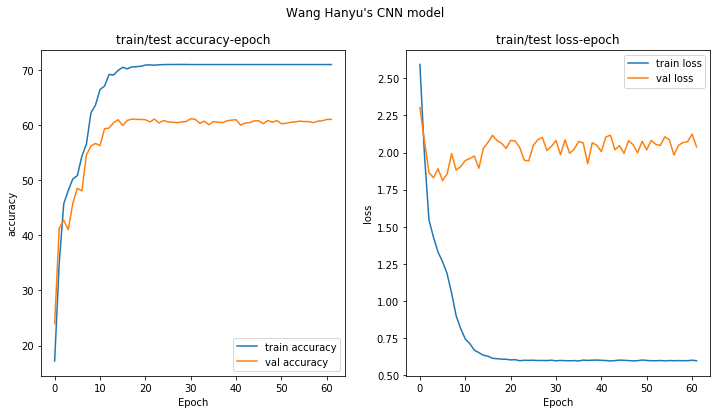

In [28]:
import matplotlib.pyplot as plt  # 画图的
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体，防止不显示中文
plt.rcParams['axes.unicode_minus'] = False  # 防止不显示负号

def plot_training_curves(train_state):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # 绘制训练集和验证集的准确率变化曲线(我服了，jupyter notebook画图中文显示不出来)
    axs[0].plot(train_state['train_acc'], label='train accuracy')
    axs[0].plot(train_state['val_acc'], label='val accuracy')
    axs[0].set_title('train/test accuracy-epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('accuracy')
    axs[0].legend()

    # 绘制训练集和验证集的损失变化曲线
    axs[1].plot(train_state['train_loss'], label='train loss')
    axs[1].plot(train_state['val_loss'], label='val loss')
    axs[1].set_title('train/test loss-epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('loss')
    axs[1].legend()

    fig.suptitle('Wang Hanyu\'s CNN model')
    plt.show()

print(f'\033[0;31m叮咚~ \033[0;32m开始训练 \033[0;33mby WA2114001王晗宇 \033[0;35m{why_time()}\033[0m')
import time  # 暂停时间的
time.sleep(0.25)  # 暂停0.25秒防止进度条错乱

# 创建用于显示训练进度的进度条
epoch_bar = tqdm_notebook(desc='训练过程', 
                          total=args.num_epochs,
                          position=0)

# 设置数据集为训练集，创建训练进度条
dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)

# 设置数据集为验证集，创建验证进度条
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)


try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 遍历训练集数据

        # 设置: 批处理生成器, 将损失和准确率设为0, 设置训练模式
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 训练过程的5个步骤:

            # --------------------------------------
            # 1. 梯度清零
            optimizer.zero_grad()

            # 2. 计算输出
            y_pred = classifier(batch_dict['x_surname'])

            # 3. 计算损失
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 4. 使用损失计算梯度
            loss.backward()

            # 5. 使用优化器更新参数
            optimizer.step()
            
            # 6. 计算准确率
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            # -----------------------------------------

            # 更新进度条
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 遍历验证集数据

        # 设置: 批处理生成器, 将损失和准确率设为0, 设置评估模式
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 2.计算输出
            y_pred =  classifier(batch_dict['x_surname'])

            # 3. 计算损失
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 6.计算准确率
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print(f'\033[0;31m叮咚~ \033[0;32m训练完毕 \033[0;33mby WA2114001王晗宇 \033[0;35m{why_time()}\033[0m')

# 训练结束后绘制曲线图
plot_training_curves(train_state)

### 3.4 测试

（1）先看测试集

In [29]:
# 加载刚才我（王晗宇）训练好的模型状态字典
classifier.load_state_dict(torch.load(train_state['model_filename']))

# 将模型移动到指定设备上
classifier = classifier.to(args.device)

# 将数据集的类别权重移动到指定设备上
dataset.class_weights = dataset.class_weights.to(args.device)

# 定义损失函数，使用类别权重
loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)

# 设置数据集为测试集
dataset.set_split('test')

# 生成测试集批处理数据
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
# 初始化损失和准确率
running_loss = 0.0
running_acc = 0.0

# 设置模型为评估模式
classifier.eval()

# 遍历测试集数据
for batch_index, batch_dict in enumerate(batch_generator):
    # 计算模型输出
    y_pred = classifier(batch_dict['x_surname'])
    
    # 计算损失
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 计算准确率
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

# 保存测试集的损失和准确率到训练状态
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [30]:
print("测试集 loss: {};".format(train_state['test_loss']))
print("测试集 Accuracy: {}".format(train_state['test_acc']))

测试集 loss: 1.8038630783557892;
测试集 Accuracy: 59.440104166666664


（2）再手动测试

In [31]:
def predict_nationality(surname, classifier, vectorizer):
    """
    输入：
        surname (str): 要分类的姓氏
        classifier (SurnameClassifer): 分类器的实例
        vectorizer (SurnameVectorizer): 对应的向量化器
    输出：
        国籍及其概率
    功能：
        从新的姓氏预测国籍
    王晗宇制作
    """
    # 将姓氏向量化
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    
    # 使用分类器进行预测，并应用softmax激活函数
    result = classifier(vectorized_surname, apply_softmax=True)

    # 获取概率值和索引
    probability_values, indices = result.max(dim=1)
    index = indices.item()

    # 查找预测的国籍
    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    # 返回包含国籍和概率的字典
    return {'国籍': predicted_nationality, '概率': probability_value}


In [32]:
new_surname = input("输入姓: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['国籍'],
                                    prediction['概率']))

输入姓:  Wang


Wang -> Chinese (p=0.69)


In [34]:
def predict_topk_nationality(surname, classifier, vectorizer, k=5):
    """
    输入：
        surname (str): 要分类的姓氏
        classifier (SurnameClassifer): 分类器的实例
        vectorizer (SurnameVectorizer): 对应的向量化器
        k (int): 返回的国籍数量
    输出：
        国籍、概率（多个）
    功能：
        从新的姓氏预测前 K 个最可能的国籍
    王晗宇制作
    """
    
    # 将姓氏向量化
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    
    # 使用分类器进行预测，并应用softmax激活函数
    prediction_vector = classifier(vectorized_surname, apply_softmax=True)
    
    # 获取前 k 个概率值和索引
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # 将结果从 Tensor 转换为 numpy 数组
    probability_values = probability_values[0].detach().numpy()
    indices = indices[0].detach().numpy()
    
    # 构建结果列表
    results = []
    for kth_index in range(k):
        nationality = vectorizer.nationality_vocab.lookup_index(indices[kth_index])
        probability_value = probability_values[kth_index]
        results.append({'国籍': nationality, '概率': probability_value})
    
    return results

# 输入要分类的姓氏
new_surname = input("输入姓：")

# 输入要查看的前 k 个预测
k = int(input("你想看几个结果？"))
if k > len(vectorizer.nationality_vocab):
    print("莓那么多国家")
    k = len(vectorizer.nationality_vocab)

# 获取前 k 个预测结果
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

# 打印前 k 个预测结果
print("前{}个结果:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['国籍'],
                                        prediction['概率']))


输入姓： Wang
你想看几个结果？ 5


前5个结果:
Wang -> Chinese (p=0.69)
Wang -> Korean (p=0.25)
Wang -> Scottish (p=0.03)
Wang -> German (p=0.01)
Wang -> English (p=0.01)


In [35]:
# 输入要分类的姓氏
new_surname = input("输入姓：")

# 输入要查看的前 k 个预测
k = int(input("你想看几个结果？"))
if k > len(vectorizer.nationality_vocab):
    print("莓那么多国家")
    k = len(vectorizer.nationality_vocab)

# 获取前 k 个预测结果
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

# 打印前 k 个预测结果
print("前{}个结果:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['国籍'],
                                        prediction['概率']))

输入姓： Newton
你想看几个结果？ 8


前8个结果:
Newton -> English (p=0.77)
Newton -> Scottish (p=0.23)
Newton -> Russian (p=0.00)
Newton -> German (p=0.00)
Newton -> Czech (p=0.00)
Newton -> Dutch (p=0.00)
Newton -> Polish (p=0.00)
Newton -> Irish (p=0.00)


In [37]:
# 输入要分类的姓氏
new_surname = input("输入姓：")

# 输入要查看的前 k 个预测
k = int(input("你想看几个结果？"))
if k > len(vectorizer.nationality_vocab):
    print("莓那么多国家")
    k = len(vectorizer.nationality_vocab)

# 获取前 k 个预测结果
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

# 打印前 k 个预测结果
print("前{}个结果:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['国籍'],
                                        prediction['概率']))

输入姓： Dong
你想看几个结果？ 5


前5个结果:
Dong -> Chinese (p=0.63)
Dong -> Irish (p=0.10)
Dong -> Vietnamese (p=0.07)
Dong -> Korean (p=0.06)
Dong -> English (p=0.04)
